<a href="https://colab.research.google.com/github/singhsourav0/Image_Caption/blob/main/caption_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**THIS CODE IS INSTRUCTED BY *GOOGLE GENERATIVE AI TEAM*.
THEY TEACH US TO CREATE OUR OWN GENERATIVE AI MODEL TO GENERATE AFTER IMAGE PROCESSING.**

***they teach me lot of thing what is the actual process in any type of generative model that i see in my real world like chatgpt, midjourny many ai/ml/dl based model and their internal process. For train our model with image caption and after processing it generate caption for image...***n

In [ ]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)

2.15.0


In [ ]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 20000  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)


219055592/219055592 [==============================] - 3s 0us/step


# New Section

In [ ]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000


def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

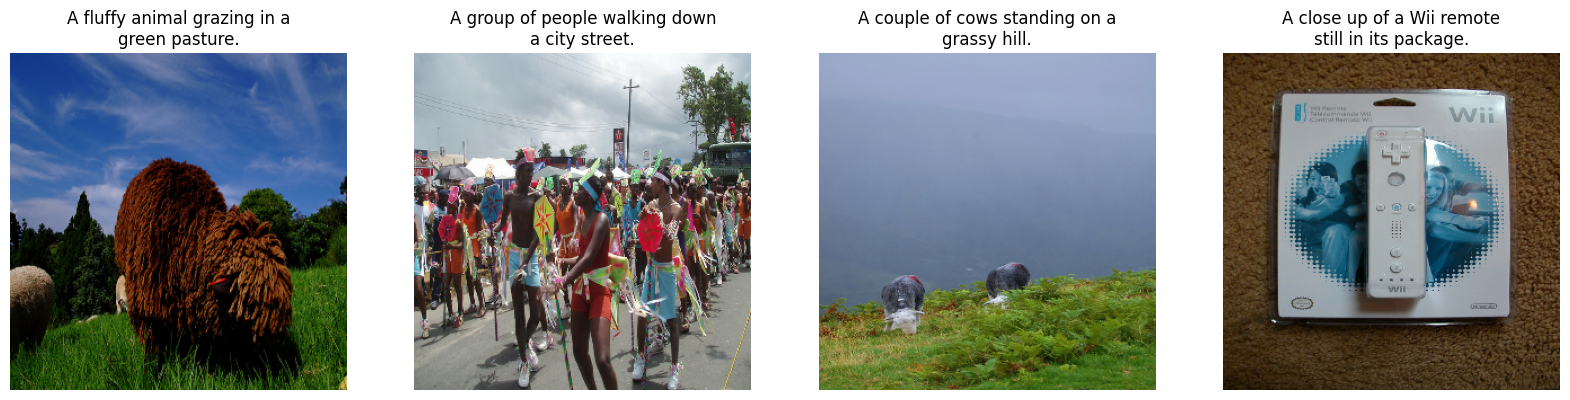

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

In [ ]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


trainds = trainds.map(add_start_end_token)

In [ ]:
MAX_CAPTION_LEN = 64


# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))

In [ ]:
tokenizer(["<start> This is a sentence <end>"])


<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 165,  11,   2,   1,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [ ]:
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy())

In [ ]:
sample_captions

[b'<start> Men with snowboards in the snow standing in front of a building. <end>',
 b'<start> A bathroom with tiled floors and walls.  <end>',
 b'<start> The jockey is riding a horse around the track. <end>',
 b'<start> A bag sitting next to a blue umbrella sticking out of rocks. <end>',
 b'<start> a little red bus going down the road by itself  <end>']

In [ ]:
print(tokenizer(sample_captions))

tf.Tensor(
[[   3   75    9 1028    8    7   67   15    8   38    5    2   71    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2   60    9  555  801   10  507    4    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    7 1510   11   34    2  114  102    7  306    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

In [ ]:
for wordid in tokenizer([sample_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> men with snowboards in the snow standing in front of a building <end>                                                   

In [ ]:
# Lookup table: Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

In [ ]:
BATCH_SIZE = 32


def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return (img_tensor, caption), target


batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
for (img, caption), label in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])


Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3    2   12   11   86    2 1136   10   72   18  177  216    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
tf.Tensor(
[   2   12   11   86    2 1136   10   72   18  177  216    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2 195  14   6  23   5   2  40   9 506   4   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  

In [ ]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)


In [ ]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55123680 (210.28 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [ ]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = Attention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

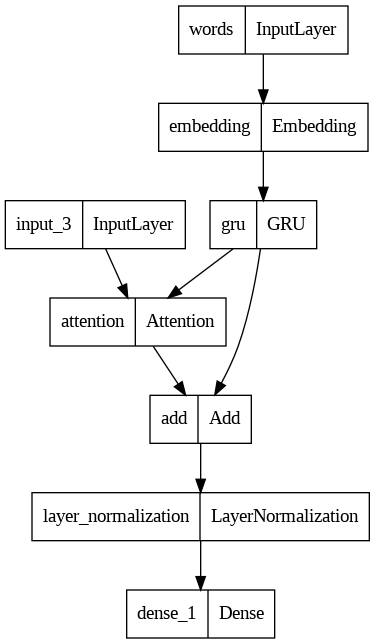

In [ ]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [ ]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 512)              1024000   ['words[0][0]']               
                                                          0                                       
                                                                                                  
 gru (GRU)                   [(None, 64, 512),            1575936   ['embedding[1][0]']           
                              (None, 512)]                                                        
                                                                                            

In [ ]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

In [ ]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)


In [ ]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=1)

2586/2586 [==============================] - 977s 367ms/step - loss: 0.5742
CPU times: user 13min 13s, sys: 1min 26s, total: 14min 40s
Wall time: 16min 34s


In [ ]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_attention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)

In [ ]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

a young woman with some people riding a surfboard.
a person sitting on a beach while wearing a red tie.
a woman with a woman standing on top of a tennis court holding onto a kite.


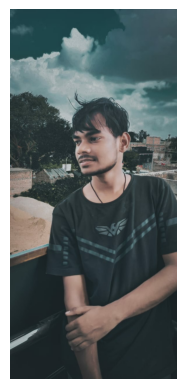

In [ ]:
filename = "/content/p1.jpeg"  # you can also try surf.jpeg

for i in range(3):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

a couple of people standing on top of a wall and one knife on a surfboard.
people in suits and one are standing next to a cake.


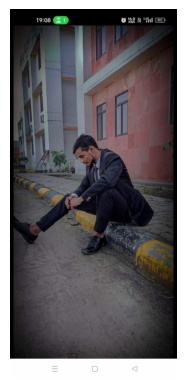

In [ ]:
filename = "/content/p2.jpeg"  # you can also try surf.jpeg

for i in range(2):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

a man sitting on a beach holding a surf board.
a man in the sand holding onto a frisbee next to a woman in the sand.


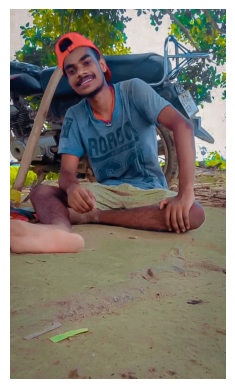

In [ ]:
filename = "/content/p3.jpeg"  # you can also try surf.jpeg

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

In [ ]:
generated_text = predict_caption(filename)


In [ ]:
print(generated_text)

(<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[0.4117647 , 0.4509804 , 0.44705883],
        [0.39274707, 0.43196276, 0.4280412 ],
        [0.35392487, 0.39314055, 0.389219  ],
        ...,
        [0.81960785, 0.8352941 , 0.87058824],
        [0.81960785, 0.8352941 , 0.87058824],
        [0.81960785, 0.8352941 , 0.87058824]],

       [[0.42697883, 0.4661945 , 0.4641747 ],
        [0.40680835, 0.44602403, 0.4435431 ],
        [0.36563277, 0.40484846, 0.4014262 ],
        ...,
        [0.8148534 , 0.8305397 , 0.8658338 ],
        [0.8148534 , 0.8305397 , 0.8658338 ],
        [0.8148534 , 0.8305397 , 0.8658338 ]],

       [[0.4580366 , 0.4972523 , 0.4991147 ],
        [0.43551278, 0.47472847, 0.47518843],
        [0.38953313, 0.42874882, 0.42634577],
        ...,
        [0.8051479 , 0.82083416, 0.8561283 ],
        [0.8051479 , 0.82083416, 0.8561283 ],
        [0.8051479 , 0.82083416, 0.8561283 ]],

       ...,

       [[0.48182192, 0.5406455 , 0.56809646],
        [0.4